In [257]:
import numpy as np
import pandas as pd
import logging
import os
import os
import sys

log = lambda msg: logging.info(msg)

root_dir = os.path.abspath(os.path.join(os.path.dirname('__file__'), '../..'))
sys.path.append(root_dir)


# Load data

In [258]:
input_dir = "C:\\dev\\play\\brainwave-data"


In [259]:
import convert

fn = "C:\\dev\\play\\brainwave-data\\2025-03-07-21-50-51\\raw.fif"
raw, input_file_without_ext, mne_filtered = convert.load_mne_file(log, fn)
yasa_df = pd.read_csv(input_file_without_ext + ".yasa.csv")


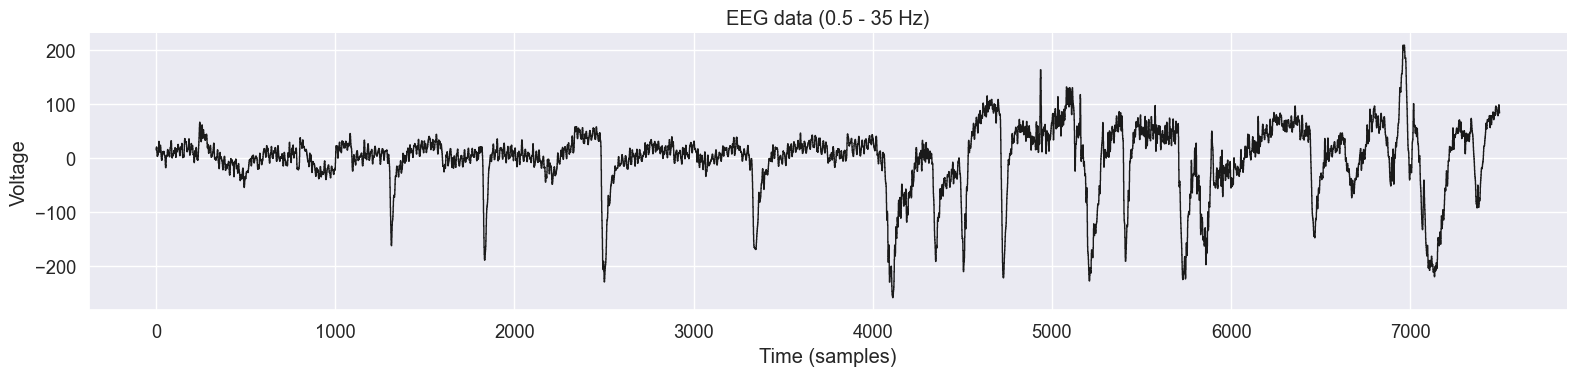

In [260]:
from notebooks.Util.DrawEpochs import plot_eeg_epoch
plot_eeg_epoch(mne_filtered, 6)

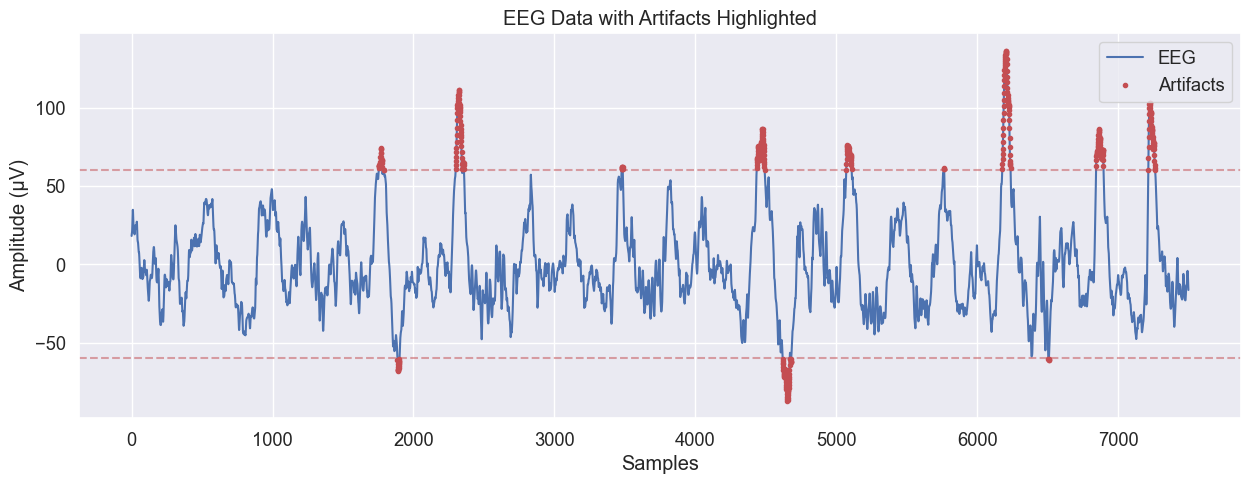

In [261]:
import matplotlib.pyplot as plt
from notebooks.Util.DrawEpochs import get_epoch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_eeg_artifacts(data, threshold=60):
    plt.figure(figsize=(15, 5))
    
    # Plot all data in blue
    plt.plot(data, 'b-', label='EEG')
    
    # Find artifact regions
    artifacts = np.where((data > threshold) | (data < -threshold))[0]
    
    # Plot artifact points in red
    plt.plot(artifacts, data[artifacts], 'r.', label='Artifacts')
    
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=-threshold, color='r', linestyle='--', alpha=0.5)
    
    plt.ylabel('Amplitude (μV)')
    plt.xlabel('Samples')
    plt.legend()
    plt.title('EEG Data with Artifacts Highlighted')
    plt.grid(True)
    
    plt.show()


eeg_data = get_epoch(mne_filtered, 102)
plot_eeg_artifacts(eeg_data)


[(1754, 1779),
 (1790, 1792),
 (1886, 1902),
 (2300, 2345),
 (2349, 2359),
 (3477, 3486),
 (4436, 4493),
 (4620, 4671),
 (4675, 4681),
 (5071, 5110),
 (5764, 5767),
 (6178, 6238),
 (6506, 6510),
 (6844, 6897),
 (7214, 7262)]

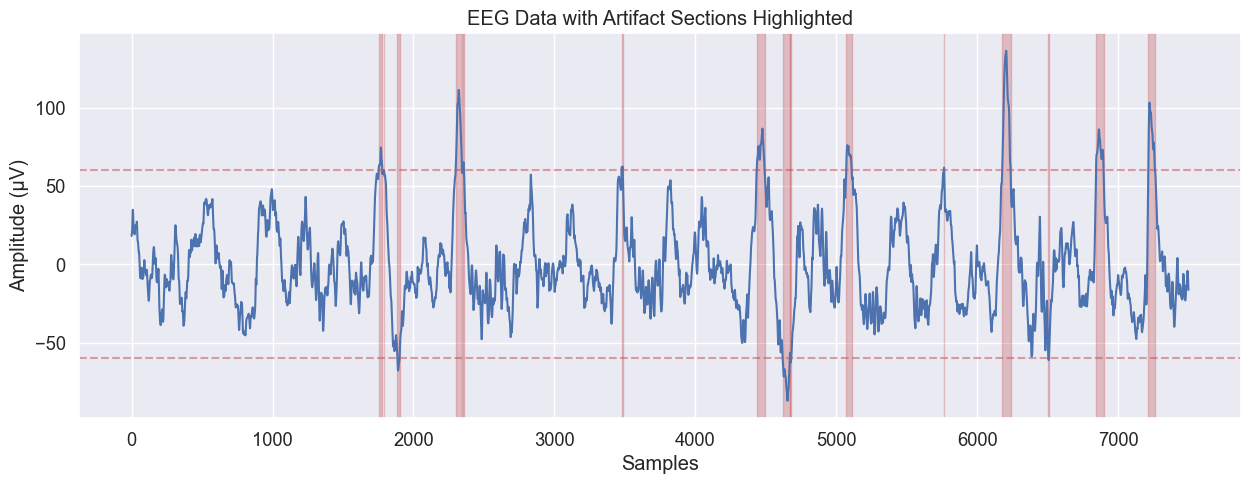

In [262]:
import matplotlib.pyplot as plt
import numpy as np

def plot_eeg_with_artifact_sections(data, threshold=60, min_duration=1):
    plt.figure(figsize=(15, 5))
    
    # Plot base data in blue
    plt.plot(data, 'b-', label='EEG')
    
    # Find where data exceeds threshold
    artifacts = np.abs(data) > threshold
    
    # Find continuous segments
    artifact_sections = []
    start = None
    
    for i in range(len(artifacts)):
        if artifacts[i] and start is None:
            start = i
        elif not artifacts[i] and start is not None:
            if (i - start) >= min_duration:
                artifact_sections.append((start, i))
            start = None
    
    # Handle case where artifact continues to end of data
    if start is not None and (len(artifacts) - start) >= min_duration:
        artifact_sections.append((start, len(artifacts)))
    
    # Highlight artifact sections in red
    for start, end in artifact_sections:
        plt.axvspan(start, end, color='r', alpha=0.3)
    
    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=-threshold, color='r', linestyle='--', alpha=0.5)
    
    plt.ylabel('Amplitude (μV)')
    plt.xlabel('Samples')
    plt.title('EEG Data with Artifact Sections Highlighted')
    plt.grid(True)
    
    return artifact_sections

plot_eeg_with_artifact_sections(eeg_data)


In [263]:
# import matplotlib.pyplot as plt
# import numpy as np

# def plot_eeg_with_merged_artifacts(data, threshold=60, min_duration=1, merge_gap=400):
#     plt.figure(figsize=(15, 5))
#     plt.plot(data, 'b-', label='EEG')
    
#     # Find where data exceeds threshold
#     artifacts = np.abs(data) > threshold
    
#     # Find continuous segments
#     artifact_sections = []
#     start = None
    
#     for i in range(len(artifacts)):
#         if artifacts[i] and start is None:
#             start = i
#         elif not artifacts[i] and start is not None:
#             if (i - start) >= min_duration:
#                 artifact_sections.append((start, i))
#             start = None
    
#     if start is not None and (len(artifacts) - start) >= min_duration:
#         artifact_sections.append((start, len(artifacts)))
    
#     # Merge sections that are close together
#     if artifact_sections:
#         merged_sections = [artifact_sections[0]]
#         for current in artifact_sections[1:]:
#             prev = merged_sections[-1]
#             if current[0] - prev[1] <= merge_gap:
#                 merged_sections[-1] = (prev[0], current[1])
#             else:
#                 merged_sections.append(current)
        
#         # Highlight merged sections
#         for start, end in merged_sections:
#             plt.axvspan(start, end, color='r', alpha=0.3)
    
#     plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5)
#     plt.axhline(y=-threshold, color='r', linestyle='--', alpha=0.5)
    
#     plt.ylabel('Amplitude (μV)')
#     plt.xlabel('Samples')
#     plt.title('EEG Data with Merged Artifact Sections')
#     plt.grid(True)
    
#     return merged_sections

# # Usage:
# # sections = plot_eeg_with_merged_artifacts(eeg_data, merge_gap=100)
# # plt.show()

# plot_eeg_with_merged_artifacts(eeg_data)


In [264]:
from eeg_artifacts import get_artifact_sections 


def plot_eeg_with_merged_artifacts(data, epoch_idx, epoch_stage, threshold=60, min_duration=100, merge_gap=400, min_section_length=1000, max_amplitude=1000, secondary_data=None, max_display_amplitude=None):
    plt.figure(figsize=(15, 5))
    if max_display_amplitude is not None:
        plt.ylim(-max_display_amplitude, max_display_amplitude)
    
    plt.plot(data, 'b-', label='EEG')
    if secondary_data is not None:
        plt.plot(secondary_data, 'g-', label='Secondary')
    
    merged_sections, artifact_sections = get_artifact_sections(data, threshold, min_duration, merge_gap, min_section_length, max_amplitude)
    
    # Create a mask for points in merged sections
    mask = np.ones(len(data), dtype=bool)
    for start, end in merged_sections:
        mask[start:end] = False
    
    # Calculate cumulative mean IQR excluding merged sections
    cumulative_mean_iqr = np.zeros_like(data, dtype=float)
    clean_data_points = []
    
    for i in range(len(data)):
        if mask[i]:
            clean_data_points.append(data[i])
        
        if len(clean_data_points) > 0:
            q75, q25 = np.percentile(np.abs(clean_data_points), [75, 25])
            cumulative_mean_iqr[i] = q75 - q25
        else:
            cumulative_mean_iqr[i] = 0
    
    # Plot cumulative mean IQR
    plt.plot(cumulative_mean_iqr, 'c-', alpha=0.7, label='Cumulative Mean IQR (Clean Data)')
    display(cumulative_mean_iqr[-1])
    
    # Highlight merged sections
    for start, end in artifact_sections:
        start_time = start      
        end_time = end
        duration = end_time - start_time
        plt.axvspan(start_time, end_time, color='r', alpha=0.3)
        # Add text box showing duration
        plt.text((start_time + end_time) / 2, max(data) * 0.9, 
                 f"{duration}", 
                 bbox=dict(facecolor='white', alpha=0.7),
                 horizontalalignment='center')
    for start, end in merged_sections:
        start_time = start
        end_time = end
        duration = end_time - start_time
        plt.axvspan(start_time, end_time, color='g', alpha=0.3)
        # Add text box showing duration
        plt.text((start_time + end_time) / 2, max(data) * 0.8, 
                 f"Merged: {duration}", 
                 bbox=dict(facecolor='white', alpha=0.7),
                 horizontalalignment='center')

    plt.axhline(y=threshold, color='r', linestyle='--', alpha=0.5)
    plt.axhline(y=-threshold, color='r', linestyle='--', alpha=0.5)

    plt.ylabel('Amplitude (μV)')
    plt.xlabel('Samples')
    plt.title(f'Epoch {epoch_idx} - {epoch_stage}')
    plt.legend()
    plt.grid(True)
    
    return merged_sections

51.2246103758344

79.00489390302442

55.57885968867453

84.97381662399322

59.86947208783823

29.414726559285114

13.936821987683109

[(5815, 6888)]

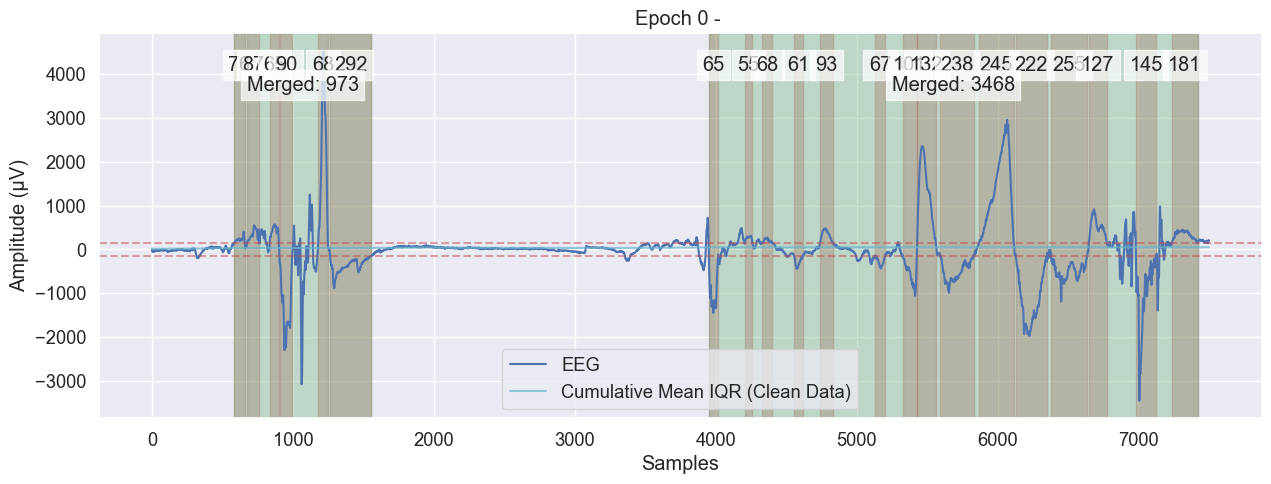

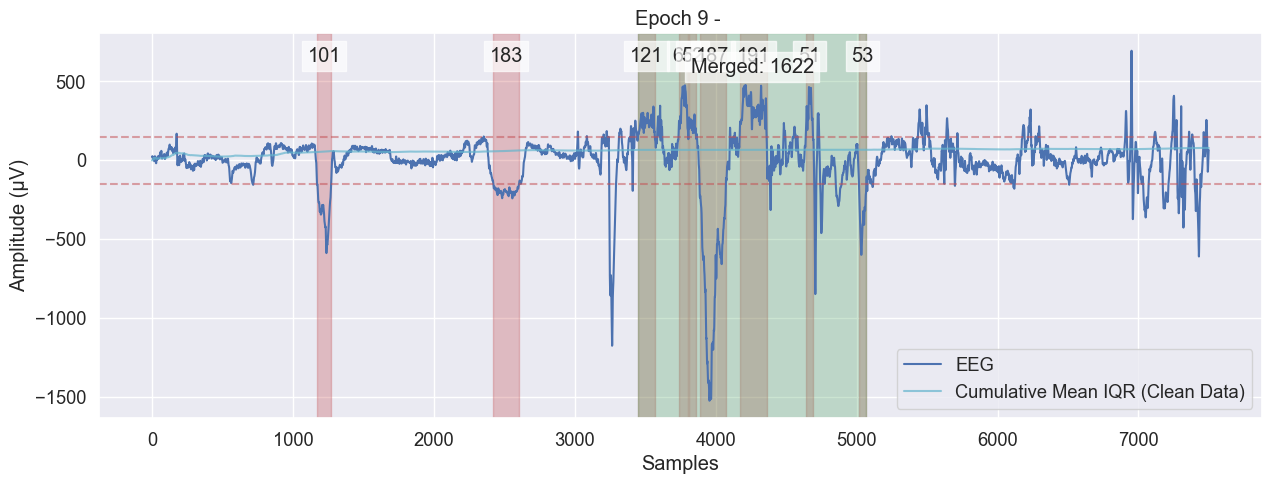

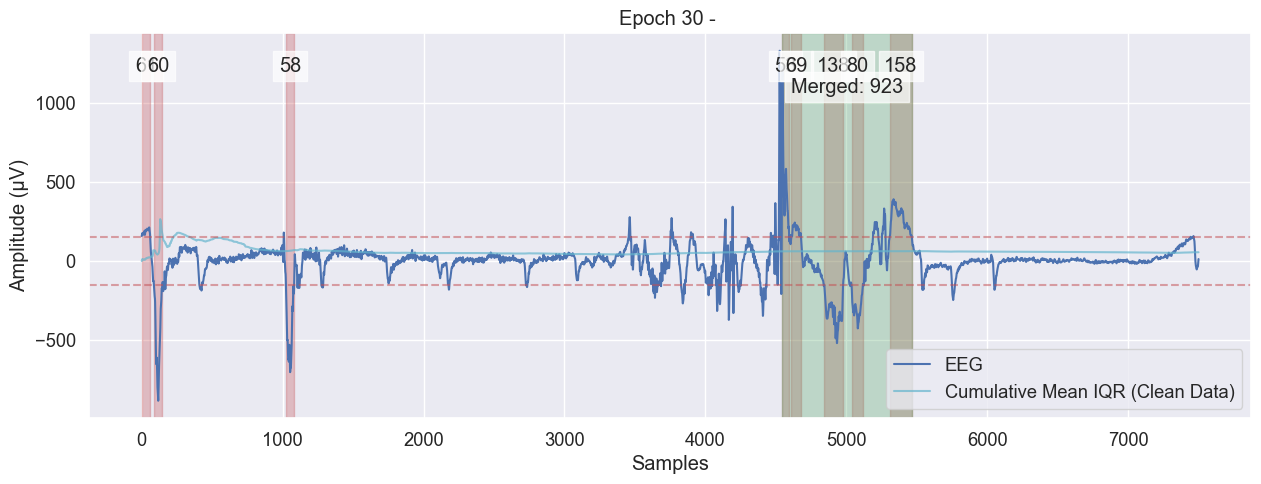

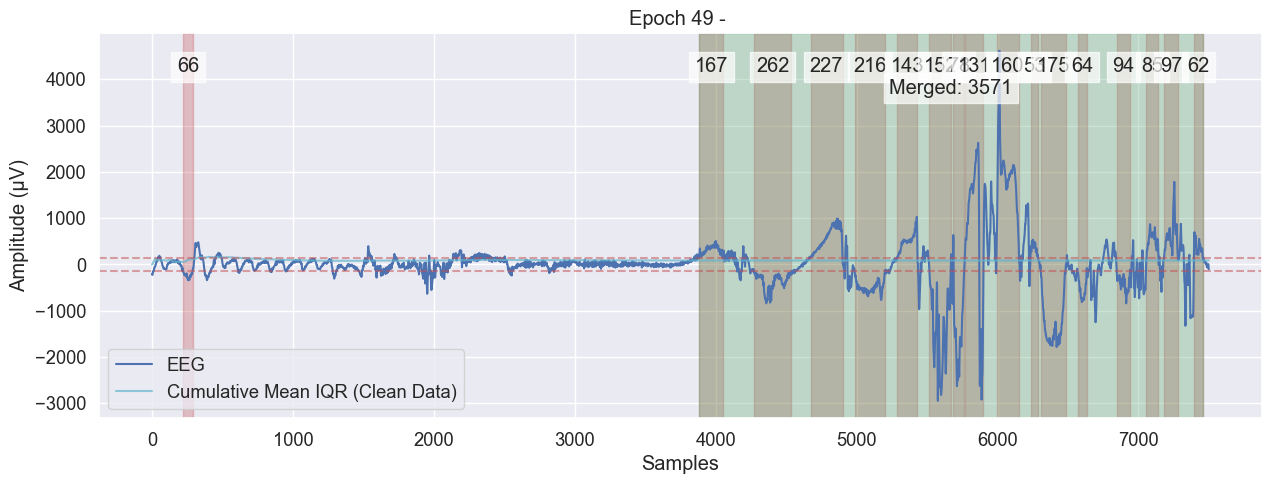

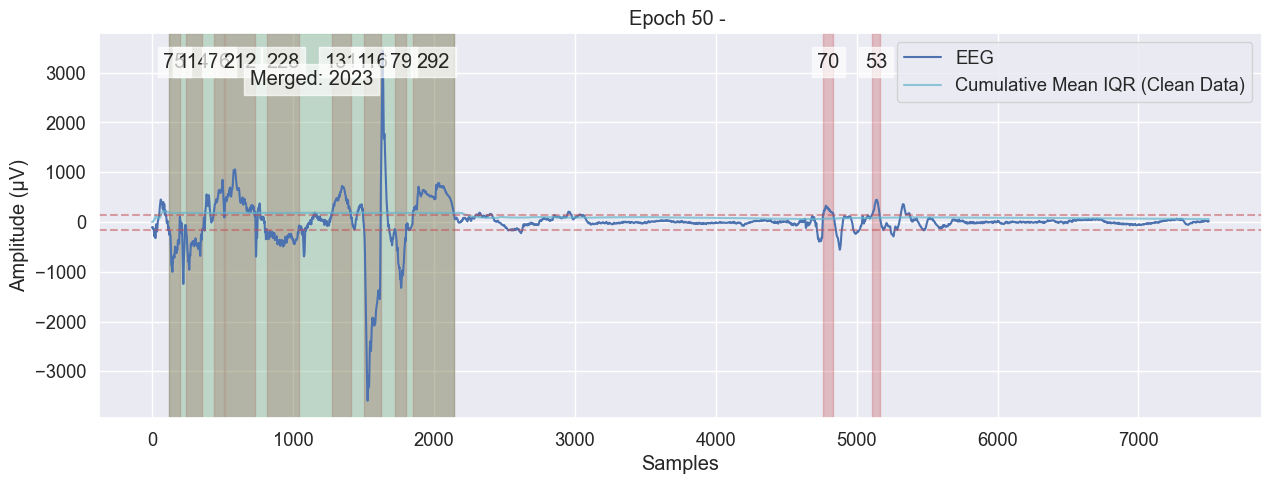

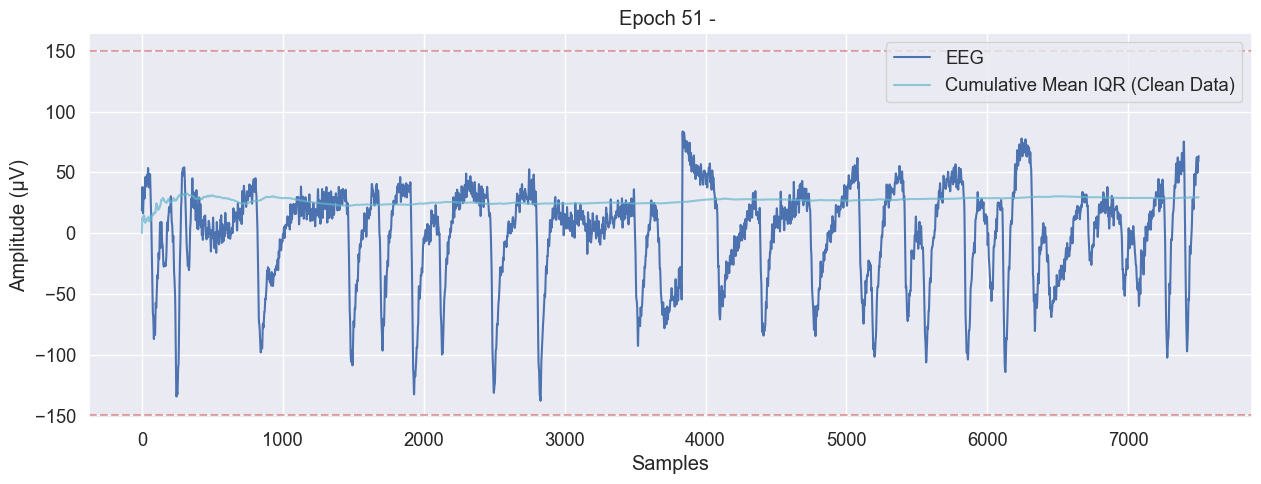

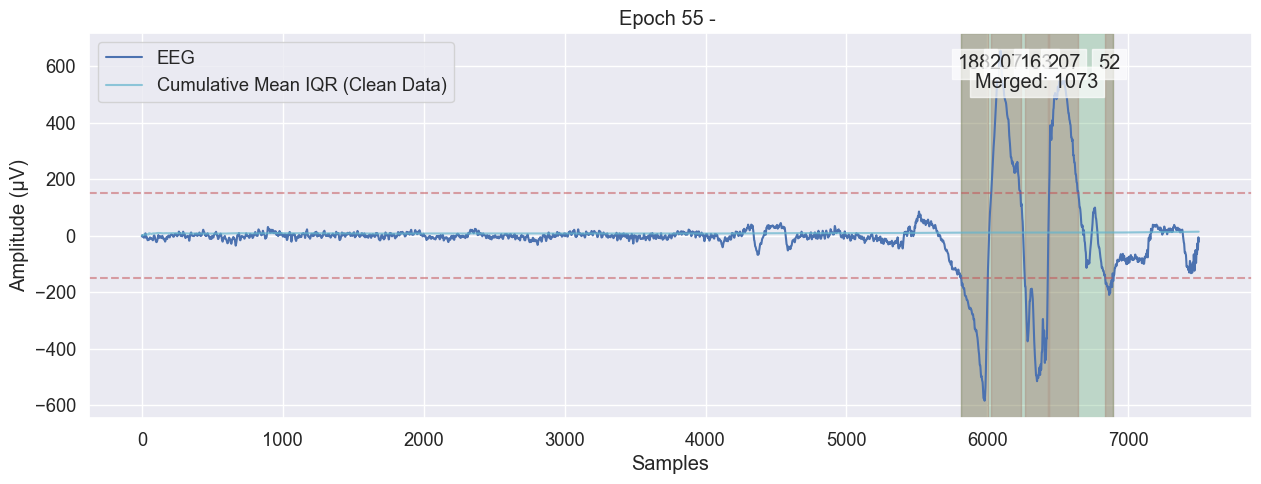

In [265]:
threshold=150
min_duration=50
merge_gap=400
min_section_length=500
plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 0), 0, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length)
plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 9), 9, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length)
plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 30), 30, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length)
plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 49), 49, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length)
plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 50), 50, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length)
plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 51), 51, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length)
plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 55), 55, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length)


In [266]:
import eeg_artifacts
reload(eeg_artifacts)
from eeg_artifacts import get_artifact_sections 



epoch = get_epoch(mne_filtered, 50)
merged_sections, artifact_sections = get_artifact_sections(epoch, threshold, min_duration, merge_gap, min_section_length, True)
merged_sections

[(121, 2144), (4765, 5163)]

N3 epochs that should not have artifacts but do 1  and should have artifacts 3


29.2923794159978

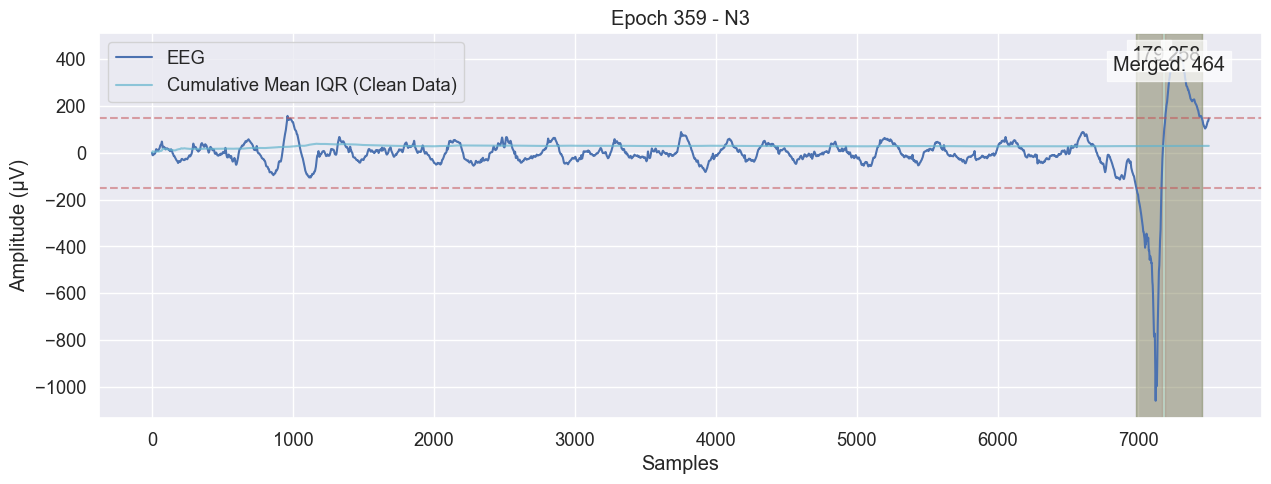

In [267]:
n3_epochs_that_really_do_have_artifacts = [359, 142, 193, 215]

n3_epochs = yasa_df[yasa_df['Stage'] == 'N3']
n3_epochs_with_artifacts = []
n3_epochs_that_should_not_have_artifacts = []

for idx, row in n3_epochs.iterrows():
    epoch = get_epoch(mne_filtered, idx)
    merged_sections, artifact_sections = get_artifact_sections(epoch, threshold, min_duration, merge_gap, min_section_length)
    if len(merged_sections) > 0:
        if idx in n3_epochs_that_really_do_have_artifacts:
            n3_epochs_with_artifacts.append(idx)
        else:
            n3_epochs_that_should_not_have_artifacts.append(idx)

print("N3 epochs that should not have artifacts but do", len(n3_epochs_that_should_not_have_artifacts), " and should have artifacts", len(n3_epochs_with_artifacts))

for idx in n3_epochs_that_should_not_have_artifacts[:5]:
    plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, idx), idx, "N3", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length)


# Saving results

In [268]:
all_data = mne_filtered.get_data(units=dict(eeg="uV"))[0]
merged_sections, _ = get_artifact_sections(all_data, amplitude_threshold=threshold, min_artifact_duration=min_duration, max_merge_gap=merge_gap, min_section_length=min_section_length)
len(merged_sections)

101

In [269]:
from eeg_artifacts import save_artifacts_to_csv

# Usage:
save_artifacts_to_csv(merged_sections, input_file_without_ext + ".artifacts.csv")

Saving artifacts to C:\dev\play\brainwave-data\2025-03-07-21-50-51\raw.artifacts.csv


# Quick artifact application

In [270]:
from importlib import reload
import yasa_features
reload(yasa_features)
import run_post_yasa_pipeline
reload(run_post_yasa_pipeline)
from tqdm.auto import tqdm
import time

def process_file(dir_name, minimal: bool = True):
    start_time = time.time()
    input_file = os.path.join(input_dir, dir_name, "raw.fif")
    print(f"Processing file: {input_file}")
    if not os.path.exists(input_file):
        print(f"File not found: {input_file}")
        return None
    file_load_start = time.time()
    raw, input_file_without_ext, mne_filtered = convert.load_mne_file(log, input_file)
    print(f"Loaded file in {time.time() - file_load_start:.4f}s")

    yasa_df = pd.read_csv(input_file_without_ext + ".yasa.csv")

    get_data_start = time.time()
    all_data1 = mne_filtered.get_data(units=dict(eeg="uV"))
    print(f"Got data in {time.time() - get_data_start:.4f}s")
    channels = raw.info['ch_names']

    all_artifacts = []
    
    for i in range(all_data1.shape[0]):
        channel = channels[i]
        data_channel = all_data1[i, :]
        sections, artifact_sections = get_artifact_sections(data_channel)
        
        for start, end in sections:
            all_artifacts.append({
                'channel': channel,
                'start': int(start),
                'end': int(end)
            })
    artifacts_df = pd.DataFrame(all_artifacts)
    yasa_feats, channel_feats_dict = yasa_features.extract_yasa_features2(log, channels, mne_filtered, artifacts_df, False, minimal, True)
    final_df = pd.concat([yasa_df, yasa_feats], axis=1)
    
    print(f"Extracted features in {time.time() - get_data_start:.4f}s")
    return final_df

# Test
process_file(day_and_night_of_dir(input_dir, '2025-02-13')[0])




Processing file: C:\dev\play\brainwave-data\2025-02-13-20-52-43\raw.fif
Loaded file in 2.0394s
Got data in 0.0329s

Processing artifact-aware data for channel Fpz-M1 (1/1)
Filtering time: 0.2026s
Window extraction time: 0.0003s
Artifact handling time: 0.1664s
Basic stats calculation time: 0.0376s
DataFrame creation time: 0.0041s
NaN handling time: 0.0003s
Downcast and sort time: 0.0000s
Total execution time: 0.4114s
         336929 function calls (335501 primitive calls) in 0.309 seconds

   Ordered by: cumulative time
   List reduced from 715 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.202    0.202 <decorator-gen-82>:1(filter_data)
        1    0.003    0.003    0.201    0.201 c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\mne\filter.py:924(filter_data)
        1    0.007    0.007    0.194    0.194 c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\mne\filter.py:279(_overlap_add_filter)

,Stage,Confidence,Epoch,Timestamp,Source,Fpz-M1_Stage,Fpz-M1_Confidence,StageInt,Fpz-M1_eeg_removed_percentage,Fpz-M1_eeg_std
0,W,0.998223,0,2025-02-13 20:52:43.554935932+00:00,Fpz-M1,W,0.998223,0,0.000000,0.000093
1,W,0.997703,1,2025-02-13 20:53:13.554935932+00:00,Fpz-M1,W,0.997703,0,0.000000,0.000095
2,W,0.999265,2,2025-02-13 20:53:43.554935932+00:00,Fpz-M1,W,0.999265,0,0.000000,0.000058
3,W,0.999053,3,2025-02-13 20:54:13.554935932+00:00,Fpz-M1,W,0.999053,0,0.000000,0.000048
4,W,0.997986,4,2025-02-13 20:54:43.554935932+00:00,Fpz-M1,W,0.997986,0,31.360001,0.000122
...,...,...,...,...,...,...,...,...,...,...
1174,W,0.990496,1174,2025-02-14 06:39:43.554935932+00:00,Fpz-M1,W,0.990496,0,7.880000,0.000086
1175,W,0.981929,1175,2025-02-14 06:40:13.554935932+00:00,Fpz-M1,W,0.981929,0,10.946667,0.000097
1176,W,0.971270,1176,2025-02-14 06:40:43.554935932+00:00,Fpz-M1,W,0.971270,0,0.000000,0.000056
1177,W,0.743450,1177,2025-02-14 06:41:13.554935932+00:00,Fpz-M1,W,0.743450,0,6.853333,0.000029


In [271]:
from notebooks.Util.DayAndNightOfFinder import day_and_night_of_dir
all_dfs = []

#dirs = next(os.walk(input_dir))[1]

most_outlying_days = ['2025-02-13'] #, '2025-01-28', '2025-01-22', '2025-01-19']
most_outlying_dirs = [day_and_night_of_dir(input_dir, day_and_night)[0] for day_and_night in most_outlying_days]
dirs = most_outlying_dirs

for idx, dir_name in enumerate(tqdm(dirs, desc="Post YASA pipeline")):
    yasa_feats = process_file(dir_name, minimal=False)
    if yasa_feats is None:
        continue
    all_dfs.append(yasa_feats)

df = pd.concat(all_dfs)


Post YASA pipeline:   0%|          | 0/1 [00:00<?, ?it/s]

Processing file: C:\dev\play\brainwave-data\2025-02-13-20-52-43\raw.fif
Loaded file in 1.2769s
Got data in 0.0347s

Processing artifact-aware data for channel Fpz-M1 (1/1)
Filtering time: 0.2238s
Window extraction time: 0.0000s
Artifact handling time: 0.1556s
Basic stats calculation time: 0.0414s
Hjorth parameters time: 0.1500s
Additional stats time: 0.7568s


c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\joblib\parallel.py:1847: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  res = func(*args, **kwargs)
c:\dev\Brainwave-Processor\yasa_features.py:188: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:188: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', verbose=0)
c:\dev\Brainwave-Processor\yasa_features.py:188: RuntimeWarning: Iterative multi-taper PSD computation did not converge.
  psd, freqs = psd_array_multitaper(epochs, sf, adaptive=True, normalization='full', 

PSD calculation time: 10.5216s
Bandpower calculation time: 0.0334s
Ratio calculations time: 0.0175s
EEG ratio time: 0.0000s
Power calculation time: 0.0130s
Entropy and fractal dimension time: 0.4669s
New features time: 0.3683s
DataFrame creation time: 0.0000s
Rolling average time: 0.0499s
NaN handling time: 0.0183s
Downcast and sort time: 0.0206s
Total execution time: 12.8387s
         2262025 function calls (2209333 primitive calls) in 12.697 seconds

   Ordered by: cumulative time
   List reduced from 1255 to 20 due to restriction <20>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.002    0.002   10.521   10.521 <decorator-gen-147>:1(psd_array_multitaper)
        1    0.033    0.033   10.518   10.518 c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\mne\time_frequency\multitaper.py:320(psd_array_multitaper)
       10    2.394    0.239   10.054    1.005 c:\Users\graha\.conda\envs\3.10-tf\lib\site-packages\mne\time_frequency\multitaper.py:78(

In [272]:
df.head()

,Stage,Confidence,Epoch,Timestamp,Source,Fpz-M1_Stage,Fpz-M1_Confidence,StageInt,Fpz-M1_eeg_abspow,Fpz-M1_eeg_abspow_c7min_norm,...,Fpz-M1_eeg_thetaab_p2min_norm,Fpz-M1_eeg_thetaabs,Fpz-M1_eeg_thetaabs_c7min_norm,Fpz-M1_eeg_thetaabs_p2min_norm,Fpz-M1_eeg_thetaabsaa,Fpz-M1_eeg_thetaabsaa_c7min_norm,Fpz-M1_eeg_thetaabsaa_p2min_norm,Fpz-M1_eeg_thetaabsab,Fpz-M1_eeg_thetaabsab_c7min_norm,Fpz-M1_eeg_thetaabsab_p2min_norm
0,W,0.998223,0,2025-02-13 20:52:43.554935932+00:00,Fpz-M1,W,0.998223,0,7.199716,2.748392,...,-0.167392,0.832232,5.169860,6.260984,1.552108,5.413697,6.981966,6.997212,2.294149,2.811378
1,W,0.997703,1,2025-02-13 20:53:13.554935932+00:00,Fpz-M1,W,0.997703,0,7.398915,2.539764,...,-0.133899,0.803020,4.863129,6.149036,1.466424,5.072690,6.785404,7.362814,2.113854,2.889129
2,W,0.999265,2,2025-02-13 20:53:43.554935932+00:00,Fpz-M1,W,0.999265,0,3.232565,2.286986,...,-0.114150,0.453149,4.504140,5.217842,0.712439,4.676943,5.566773,3.040899,1.892222,2.302295
3,W,0.999053,3,2025-02-13 20:54:13.554935932+00:00,Fpz-M1,W,0.999053,0,1.898666,2.078019,...,-0.063489,0.239227,4.190805,4.342337,0.345812,4.349782,4.536932,1.916595,1.710608,1.889326
4,W,0.997986,4,2025-02-13 20:54:43.554935932+00:00,Fpz-M1,W,0.997986,0,9.563228,1.918933,...,-0.148262,1.659767,3.953530,5.928026,3.169270,4.115306,6.391841,8.753087,1.570050,2.076034


# Find outliers

In [273]:
icols = [col for col in df.columns if "_norm" not in col and ('_eeg' in col or 'Stage' in col) and not col.endswith("_s") and not col.endswith("aa") and not col.endswith("ab") and not col.endswith("_dt") and not col.endswith("_ds") and not col.endswith("_db") and not col.endswith("_at")]
icols

['Stage',
 'Fpz-M1_Stage',
 'StageInt',
 'Fpz-M1_eeg_abspow',
 'Fpz-M1_eeg_alpha',
 'Fpz-M1_eeg_alphaabs',
 'Fpz-M1_eeg_auc',
 'Fpz-M1_eeg_beta',
 'Fpz-M1_eeg_betaabs',
 'Fpz-M1_eeg_fdelta',
 'Fpz-M1_eeg_fdeltaabs',
 'Fpz-M1_eeg_hcomp',
 'Fpz-M1_eeg_higuchi',
 'Fpz-M1_eeg_hmob',
 'Fpz-M1_eeg_iqr',
 'Fpz-M1_eeg_kurt',
 'Fpz-M1_eeg_nzc',
 'Fpz-M1_eeg_perm',
 'Fpz-M1_eeg_petrosian',
 'Fpz-M1_eeg_removed_percentage',
 'Fpz-M1_eeg_sdelta',
 'Fpz-M1_eeg_sdeltaabs',
 'Fpz-M1_eeg_sigma',
 'Fpz-M1_eeg_sigmaabs',
 'Fpz-M1_eeg_skew',
 'Fpz-M1_eeg_specent',
 'Fpz-M1_eeg_spectral_centroid',
 'Fpz-M1_eeg_std',
 'Fpz-M1_eeg_theta',
 'Fpz-M1_eeg_thetaabs']

In [274]:
import scaling
reload(scaling)
idf = df[icols]
stats = scaling.stats(idf)
stats.head()

,Column,P10,P90,Min,Max,Mean,Std,Z-Score-Max,W_P10,W_P90,...,Sleep_Mean,Sleep_Std,Sleep_Z-Score-Max,NonDeepSleep_P10,NonDeepSleep_P90,NonDeepSleep_Min,NonDeepSleep_Max,NonDeepSleep_Mean,NonDeepSleep_Std,NonDeepSleep_Z-Score-Max
0,Fpz-M1_eeg_abspow,0.041458,1.364621,0.026984,9.563228,0.597075,0.903332,9.925643,0.207923,2.484324,...,0.363538,0.532352,12.401659,0.040331,1.388484,0.026984,9.563228,0.546931,0.956282,9.428491
1,Fpz-M1_eeg_alpha,0.008139,0.095624,0.000132,0.303640,0.041769,0.041386,6.327447,0.006239,0.040793,...,0.046413,0.035898,4.440225,0.009020,0.099554,0.000132,0.303640,0.047421,0.043146,5.938470
2,Fpz-M1_eeg_alphaabs,0.003374,0.016788,0.000372,0.462226,0.010830,0.019803,22.794205,0.007727,0.032020,...,0.007594,0.004694,10.002428,0.003229,0.017459,0.000372,0.462226,0.010875,0.021671,20.827778
3,Fpz-M1_eeg_auc,0.042531,0.224867,0.033615,1.435670,0.128131,0.119775,10.916649,0.089202,0.411754,...,0.098022,0.068011,10.128373,0.041504,0.228902,0.033615,1.435670,0.118430,0.126340,10.426119
4,Fpz-M1_eeg_beta,0.002112,0.051986,0.000275,0.193565,0.021525,0.022433,7.669107,0.006064,0.059469,...,0.019968,0.020727,7.745182,0.004870,0.055224,0.000275,0.193565,0.025449,0.022693,7.408244


In [275]:
stats.sort_values(by='Z-Score-Max', ascending=False)

,Column,P10,P90,Min,Max,Mean,Std,Z-Score-Max,W_P10,W_P90,...,Sleep_Mean,Sleep_Std,Sleep_Z-Score-Max,NonDeepSleep_P10,NonDeepSleep_P90,NonDeepSleep_Min,NonDeepSleep_Max,NonDeepSleep_Mean,NonDeepSleep_Std,NonDeepSleep_Z-Score-Max
20,Fpz-M1_eeg_sigmaabs,0.001333,0.006559,0.000289,0.332431,0.004529,0.013414,24.445391,0.002791,0.019550,...,0.002328,0.002142,14.145570,0.001353,0.007426,0.000289,0.332431,0.005068,0.014660,22.330803
2,Fpz-M1_eeg_alphaabs,0.003374,0.016788,0.000372,0.462226,0.010830,0.019803,22.794205,0.007727,0.032020,...,0.007594,0.004694,10.002428,0.003229,0.017459,0.000372,0.462226,0.010875,0.021671,20.827778
26,Fpz-M1_eeg_thetaabs,0.006916,0.082370,0.003245,1.659767,0.033880,0.075665,21.488081,0.009871,0.167173,...,0.013755,0.007960,10.114041,0.006678,0.094256,0.003245,1.659767,0.036384,0.082772,19.612619
5,Fpz-M1_eeg_betaabs,0.001343,0.023232,0.000963,0.714845,0.012078,0.040177,17.491915,0.004431,0.096973,...,0.002932,0.005764,12.900584,0.001521,0.027522,0.001028,0.714845,0.014153,0.043790,16.001171
11,Fpz-M1_eeg_iqr,0.000009,0.000040,0.000007,0.000348,0.000022,0.000023,14.237067,0.000013,0.000070,...,0.000018,0.000012,10.714696,0.000009,0.000030,0.000007,0.000348,0.000019,0.000024,13.884110
16,Fpz-M1_eeg_removed_percentage,0.000000,1.216000,0.000000,100.000000,1.765768,7.797359,12.598398,0.000000,20.026667,...,0.434342,2.297199,12.307305,0.000000,5.478667,0.000000,100.000000,2.039347,8.452354,11.589747
7,Fpz-M1_eeg_fdeltaabs,0.015350,0.597107,0.004901,4.702698,0.244193,0.374465,11.906336,0.049386,1.080147,...,0.133718,0.173068,12.465622,0.014580,0.609067,0.004901,4.702698,0.228788,0.402157,11.124777
3,Fpz-M1_eeg_auc,0.042531,0.224867,0.033615,1.435670,0.128131,0.119775,10.916649,0.089202,0.411754,...,0.098022,0.068011,10.128373,0.041504,0.228902,0.033615,1.435670,0.118430,0.126340,10.426119
0,Fpz-M1_eeg_abspow,0.041458,1.364621,0.026984,9.563228,0.597075,0.903332,9.925643,0.207923,2.484324,...,0.363538,0.532352,12.401659,0.040331,1.388484,0.026984,9.563228,0.546931,0.956282,9.428491
12,Fpz-M1_eeg_kurt,0.254276,14.333099,-0.817959,64.692169,5.587572,6.464225,9.143339,1.012663,16.163134,...,4.638493,6.088004,6.761422,0.259682,15.485543,-0.817959,64.692169,6.341711,6.787091,8.597271


# Investigate specific outliers

In [276]:
icol = 'Fpz-M1_eeg_iqr'
col_data = df[icol]
display(df[icol].describe())
mean = col_data.mean() 
std = col_data.std()
z_score = (col_data - mean) / std
display(mean, std)
#df[z_score > 5][['Timestamp', 'Epoch', 'Stage', icol]]
df[['Timestamp', 'Epoch', 'Stage', icol]]


count    1173.000000
mean        0.000022
std         0.000023
min         0.000007
25%         0.000011
50%         0.000015
75%         0.000026
max         0.000348
Name: Fpz-M1_eeg_iqr, dtype: float64

2.2127755e-05

2.286448e-05

,Timestamp,Epoch,Stage,Fpz-M1_eeg_iqr
0,2025-02-13 20:52:43.554935932+00:00,0,W,0.000070
1,2025-02-13 20:53:13.554935932+00:00,1,W,0.000073
2,2025-02-13 20:53:43.554935932+00:00,2,W,0.000037
3,2025-02-13 20:54:13.554935932+00:00,3,W,0.000032
4,2025-02-13 20:54:43.554935932+00:00,4,W,0.000135
...,...,...,...,...
1174,2025-02-14 06:39:43.554935932+00:00,1174,W,0.000064
1175,2025-02-14 06:40:13.554935932+00:00,1175,W,0.000040
1176,2025-02-14 06:40:43.554935932+00:00,1176,W,0.000029
1177,2025-02-14 06:41:13.554935932+00:00,1177,W,0.000014


In [277]:
import notebooks.Util.DayAndNightOfFinder
reload(notebooks.Util.DayAndNightOfFinder)
import convert
reload(convert)

ts = '2025-02-13 22:22:43.554935932+00:00'
day_and_night = notebooks.Util.DayAndNightOfFinder.day_and_night_of(ts)
full_dir, just_dir = notebooks.Util.DayAndNightOfFinder.day_and_night_of_dir(input_dir, day_and_night)
raw, input_file_without_ext, mne_filtered = convert.load_mne_file(log, full_dir + "/raw.fif")

28.662511778406603

[(4675, 6522)]

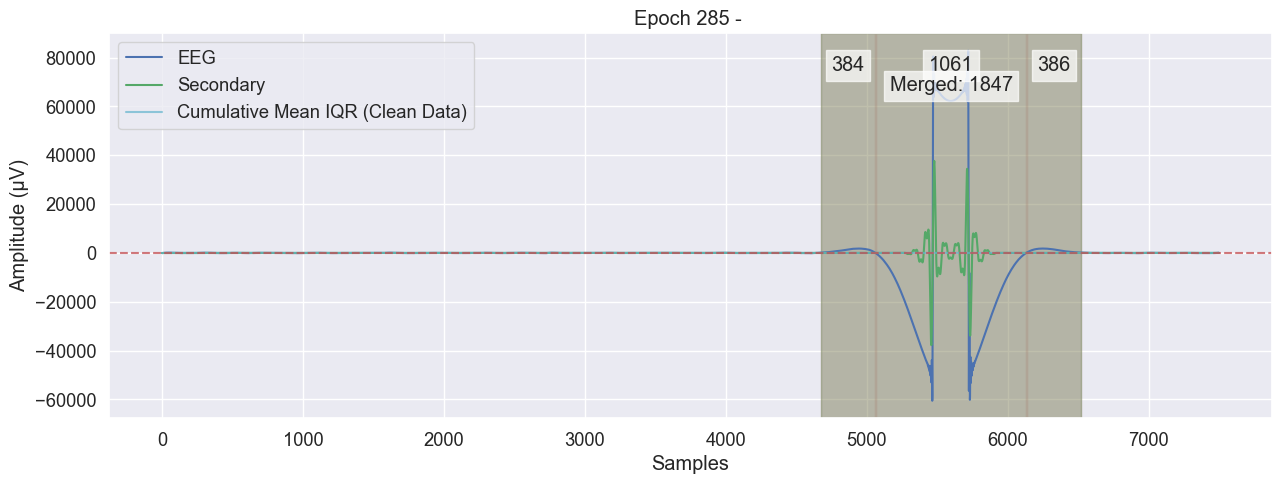

In [278]:
import notebooks.Util.DrawEpochs
reload(notebooks.Util.DrawEpochs)
from mne.filter import filter_data

# Because I was interested in theta band here
dt_filt = filter_data(mne_filtered.get_data(units=dict(eeg="uV"))[0], 250, l_freq=4, h_freq=8, verbose=False, method='fir')

#secondary_data = get_epoch(dt_filt, 33)

# plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 33), 33, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length, secondary_data=None)
# plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 52), 52, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length, secondary_data=None)
# plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 64), 64, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length, secondary_data=get_epoch(dt_filt, 64), max_display_amplitude=100)
# plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 142), 142, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length, secondary_data=get_epoch(dt_filt, 142), max_display_amplitude=100)
plot_eeg_with_merged_artifacts(get_epoch(mne_filtered, 285), 285, "", threshold=threshold, min_duration=min_duration, merge_gap=merge_gap, min_section_length=min_section_length, secondary_data=get_epoch(dt_filt, 285))
